In [35]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as Rot

In [36]:
def rot_mat_2d(angle):
    return Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]

rot_mat_2d(180) # 2 * 2

array([[-0.59846007,  0.80115264],
       [-0.80115264, -0.59846007]])

In [37]:
# covariance location x, y, yaw, velocity,

Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0]) **2
Q # 4 * 4

array([[1.0000000e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e-02, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 3.0461742e-04, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

In [38]:

# oboservation x, y position covariance
R = np.diag([0.5, 0.5])**2
R # 2 * 2

array([[0.25, 0.  ],
       [0.  , 0.25]])

In [39]:
INPUT_NOISE = np.diag([1.0, np.deg2rad(30.0)])**2
INPUT_NOISE # 2 *2

array([[1.        , 0.        ],
       [0.        , 0.27415568]])

In [40]:
GPS_NOISE = np.diag([0.5, 0.5]) ** 2
GPS_NOISE # 2 * 2

array([[0.25, 0.  ],
       [0.  , 0.25]])

In [41]:
delta_time = 0.1
SIM_TIME = 50.0
show_animation = True

In [42]:
def calc_input_u():
    # u= [velocity, yaw_angle_velocity]
    vel = 1.0
    yaw_angle_vel = 0.1

    u = np.array([[vel], [yaw_angle_vel]])
    return u
calc_input_u()

array([[1. ],
       [0.1]])

In [43]:
def motion_model_f(x_k_1, u_k_1):
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[delta_time * math.cos(x_k_1[2, 0]), 0],
                  [delta_time * math.sin(x_k_1[2, 0]), 0],
                  [0.0, delta_time],
                  [1.0, 0.0]])

    x_k = F @ x_k_1 + B @ u_k_1

    return x_k


In [44]:
def observation_model_h(x_k):
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z_k = H @ x_k

    return z_k

In [45]:
def observation(x_k_1, x_dead_reckon, u_k):
    x_k = motion_model_f(x_k_1, u_k)

    # add noise to gps x-y
    z_k_with_noise = observation_model_h(x_k) + GPS_NOISE @ np.random.randn(2, 1)

    # add noise to input
    u_k_with_noise = u_k + INPUT_NOISE @ np.random.randn(2, 1)

    x_k_with_noise = motion_model_f(x_dead_reckon, u_k_with_noise)

    return x_k, z_k_with_noise, x_k_with_noise, u_k_with_noise


In [46]:
def jacob_f(x, u):
    """
    Jacobian of Motion Model

    motion model
    x_{t+1} = x_t+v*dt*cos(yaw)
    y_{t+1} = y_t+v*dt*sin(yaw)
    yaw_{t+1} = yaw_t+omega*dt
    v_{t+1} = v{t}
    so
    dx/dyaw = -v*dt*sin(yaw)
    dx/dv = dt*cos(yaw)
    dy/dyaw = v*dt*cos(yaw)
    dy/dv = dt*sin(yaw)
    """
    yaw = x[2, 0]
    v = u[0, 0]
    jacobian_F = np.array([
        [1.0, 0.0, -delta_time * v * math.sin(yaw), delta_time * math.cos(yaw)],
        [0.0, 1.0, delta_time * v * math.cos(yaw), delta_time * math.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jacobian_F


In [47]:
def jacob_h():
    # Jacobian of Observation Model
    jacobian_H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    return jacobian_H

In [48]:
def ekf_estimation(x_estimation, P_estimation, z, u):
    #  Predict
    # 1.
    x_prediction = motion_model_f(x_estimation, u)
    # 1.1
    jacobian_F = jacob_f(x_estimation, u)
    # 2.
    P_prediction = jacobian_F @ P_estimation @ jacobian_F.T + Q
    # 2.1
    jacobian_H = jacob_h()
    
    z_prediction = observation_model_h(x_prediction)
    # 3.
    y = z - z_prediction
    # 4.
    S = jacobian_H @ P_prediction @ jacobian_H.T + R
    #  Update
    # 5.
    K = P_prediction @ jacobian_H.T @ np.linalg.inv(S)
    # 6.
    x_estimation = x_prediction + K @ y
    # 7.   
    P_estimation = (np.eye(len(x_estimation)) - K @ jacobian_H) @ P_prediction

    return x_estimation, P_estimation
    

In [49]:
def plot_covariance_ellipse(x_estimation, P_estimation):  # pragma: no cover
    Pxy = P_estimation[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[1, bigind], eigvec[0, bigind])
    fx = rot_mat_2d(angle) @ (np.array([x, y]))
    px = np.array(fx[0, :] + x_estimation[0, 0]).flatten()
    py = np.array(fx[1, :] + x_estimation[1, 0]).flatten()
    plt.plot(px, py, "--r")

In [50]:
def main():

    time = 0.0

    # State Vector [x y yaw v]'
    x_k_1_pred = np.zeros((4, 1))
    x_estimation = np.zeros((4, 1))
    P_estimation = np.eye(4)

    x_dead_reckon = np.zeros((4, 1))  # Dead reckoning

    # history
    history_true = x_k_1_pred
    history_est = x_estimation
    history_dead_reckon = x_dead_reckon
    history_z = np.zeros((2, 1))

    while SIM_TIME >= time:
        time += delta_time
        u_k = calc_input_u()

        x_k_1_pred, z_k, x_dead_reckon_new, u_k_with_noise = observation(x_k_1_pred, x_dead_reckon, u_k)

        x_pred, P_pred = ekf_estimation(x_estimation, P_estimation, z_k, u_k_with_noise)

        # store data history
        history_est = np.hstack((history_est, x_pred))
        history_dead_reckon = np.hstack((history_dead_reckon, x_dead_reckon_new))
        history_true = np.hstack((history_true, x_k_1_pred))
        history_z = np.hstack((history_z, z_k))
        x_estimation = x_pred
        P_estimation = P_pred
        x_dead_reckon = x_dead_reckon_new

        if show_animation:
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect('key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
            
            # plot the history z
            plt.plot(history_z[0, :], history_z[1, :], ".g")
            
            # plot the history true
            plt.plot(history_true[0, :].flatten(),
                     history_true[1, :].flatten(), "-b")
            
            # plot the history of dead reacon
            plt.plot(history_dead_reckon[0, :].flatten(),
                     history_dead_reckon[1, :].flatten(), "-y")
            
            # plot the history estimation
            plt.plot(history_est[0, :].flatten(),
                     history_est[1, :].flatten(), "-r")
            
            # plot the covariance         
            plot_covariance_ellipse(x_pred, P_pred)

            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.001)

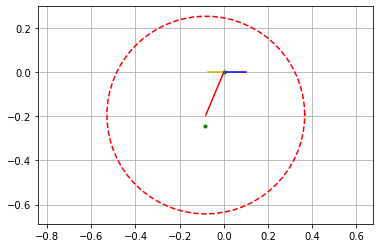

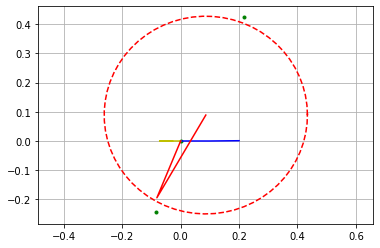

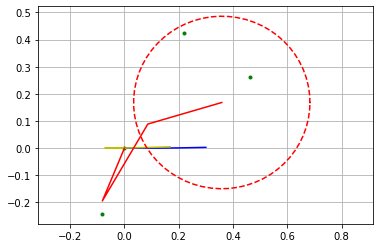

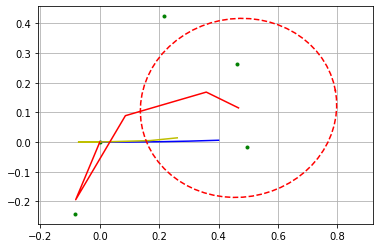

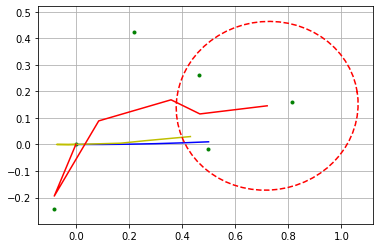

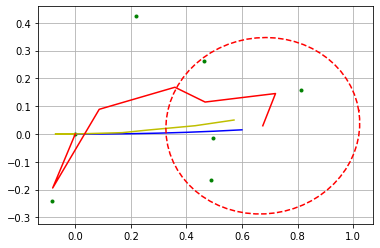

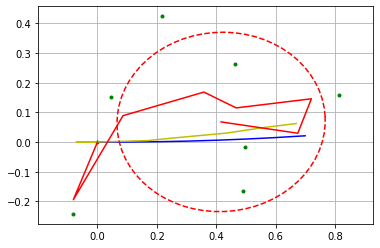

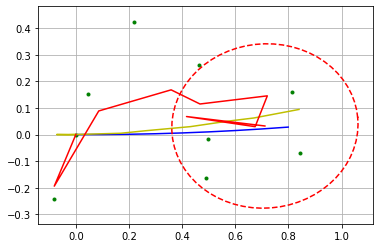

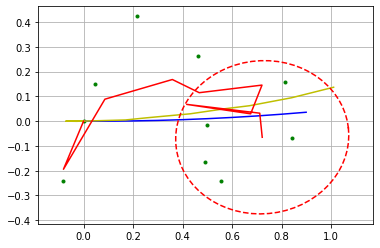

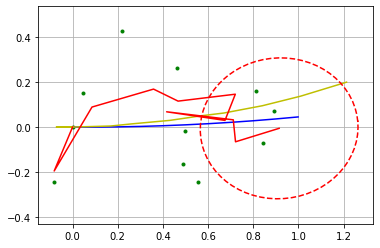

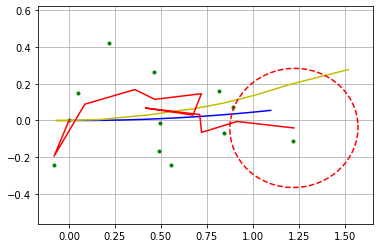

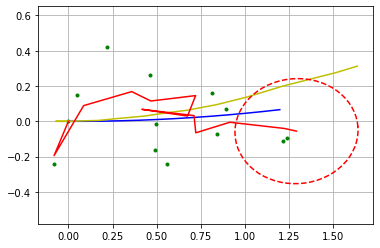

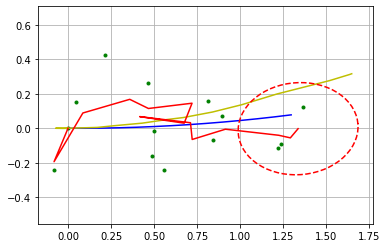

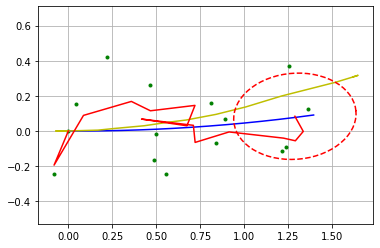

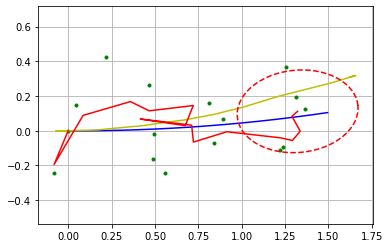

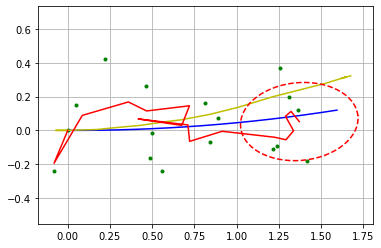

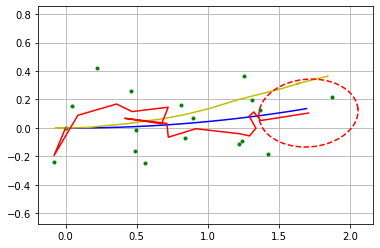

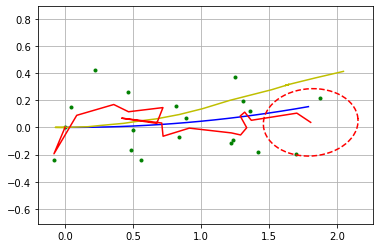

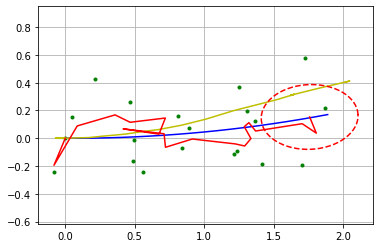

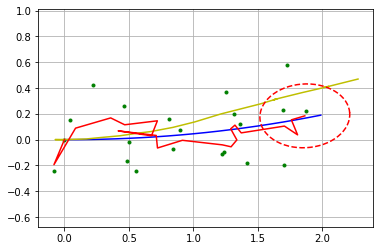

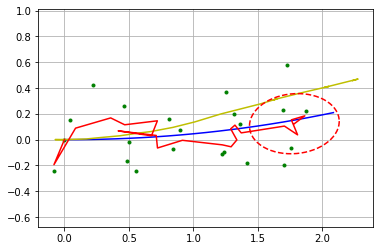

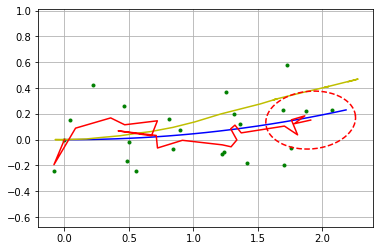

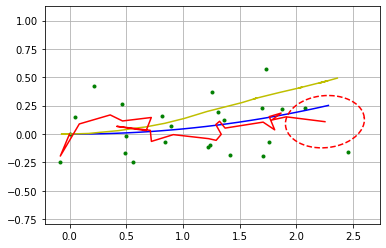

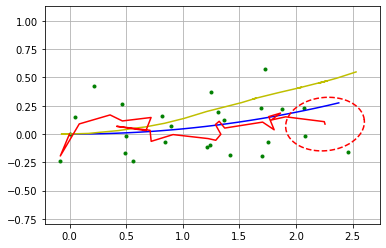

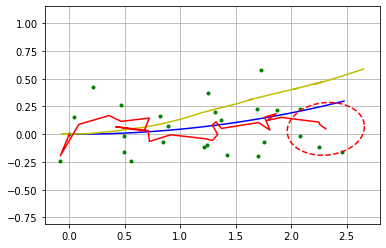

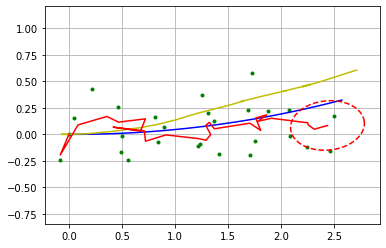

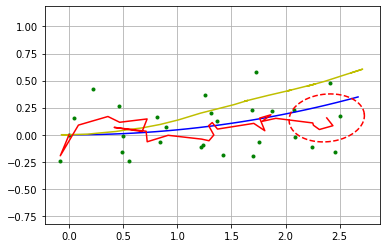

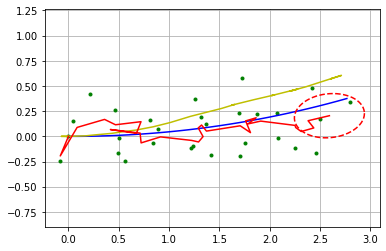

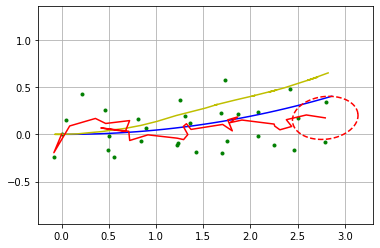

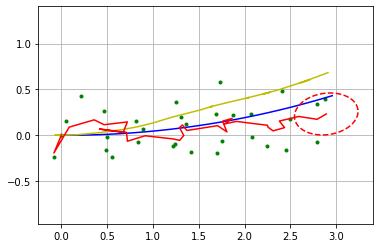

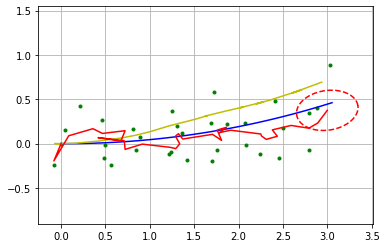

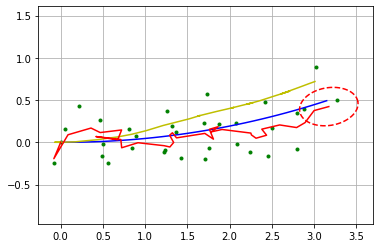

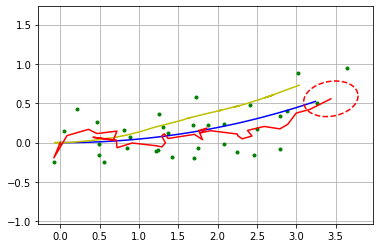

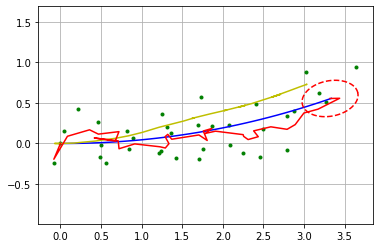

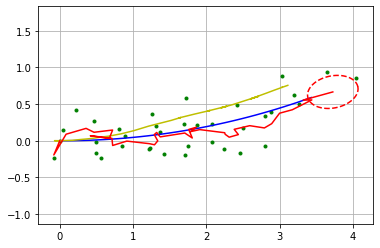

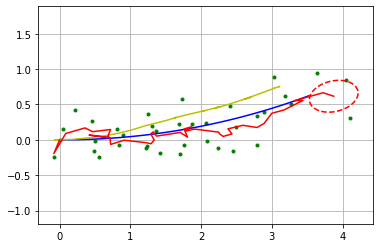

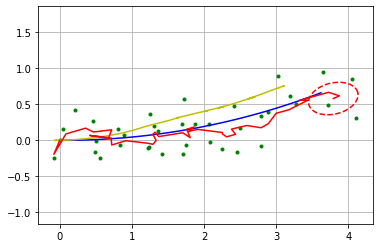

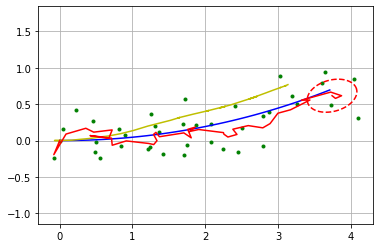

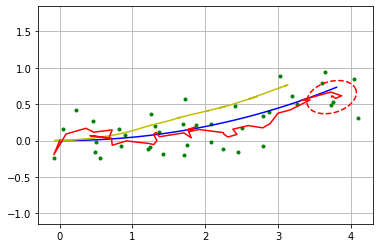

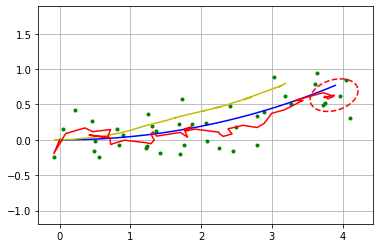

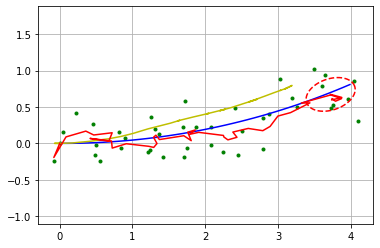

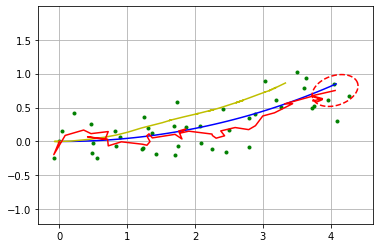

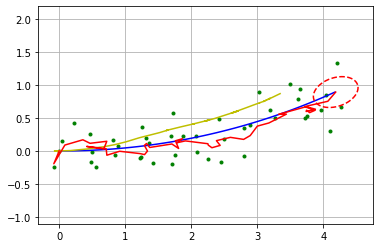

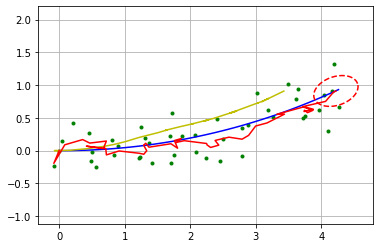

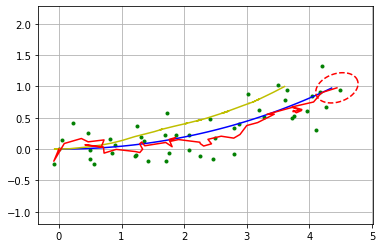

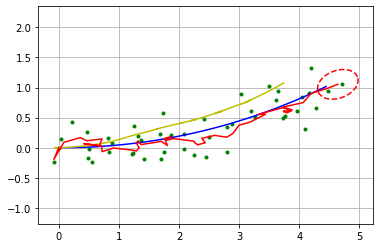

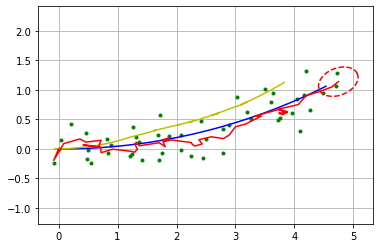

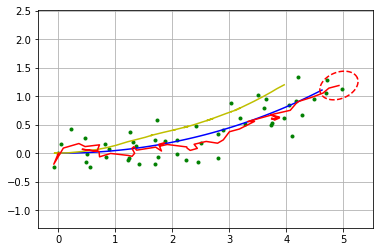

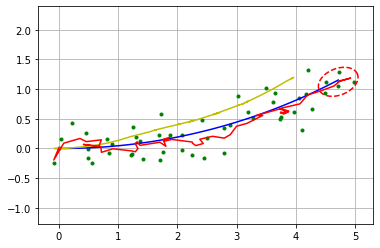

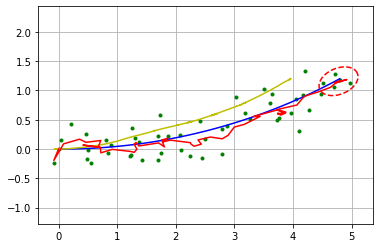

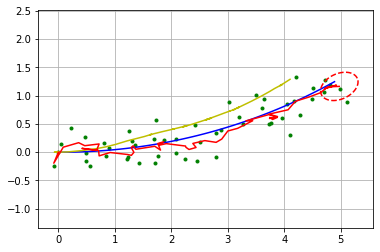

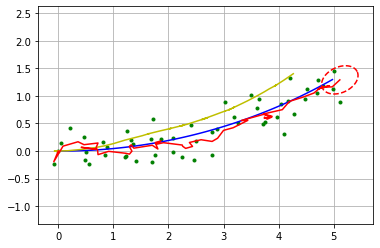

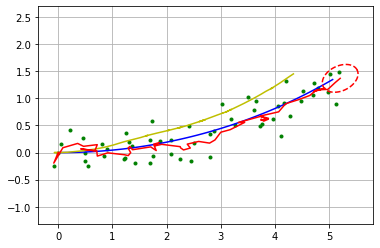

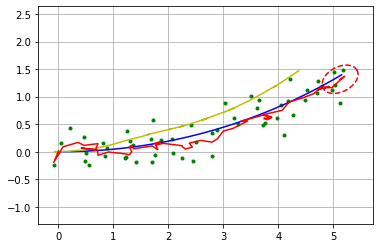

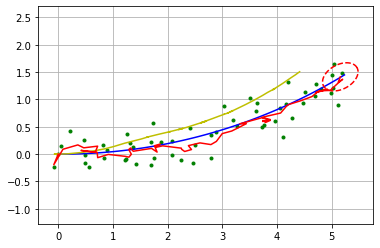

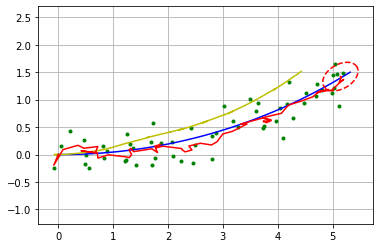

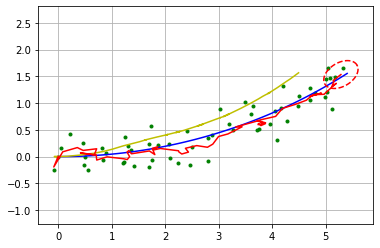

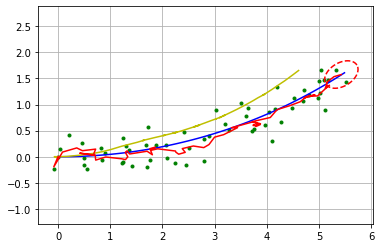

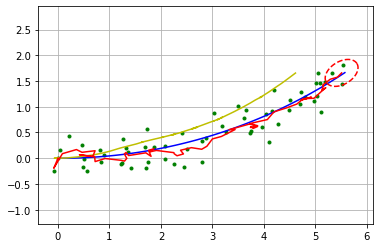

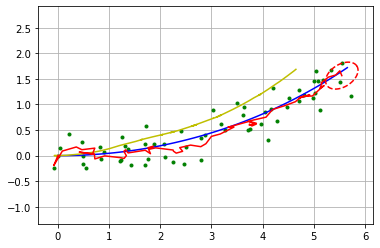

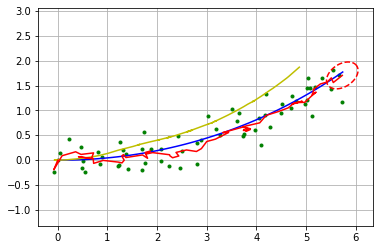

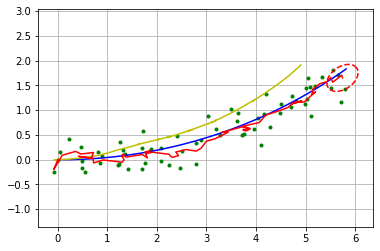

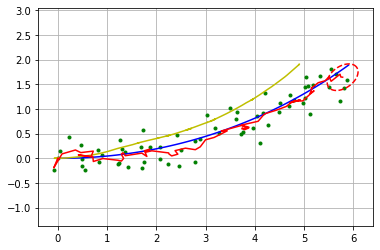

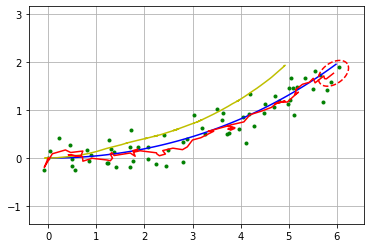

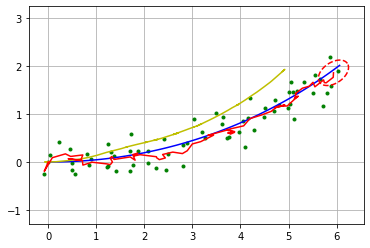

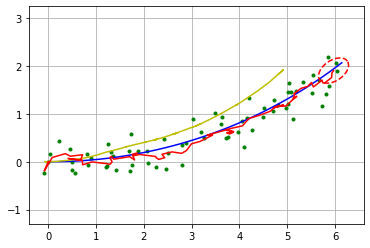

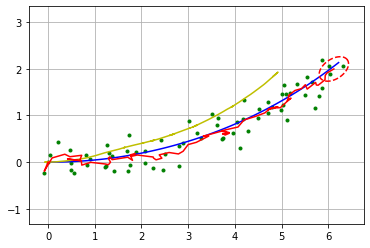

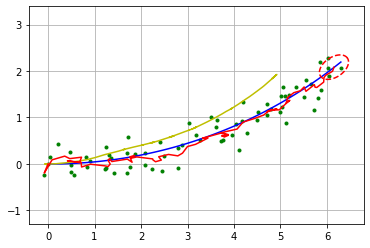

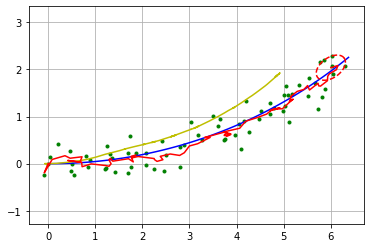

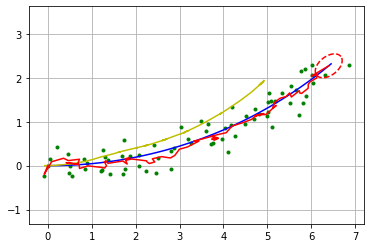

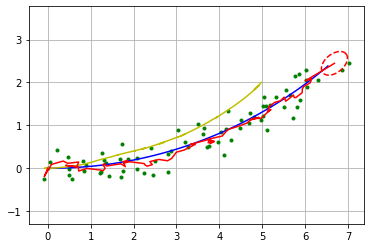

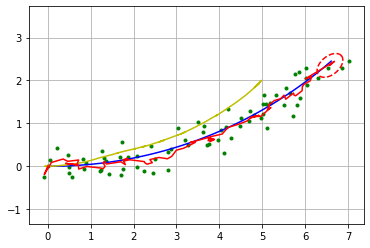

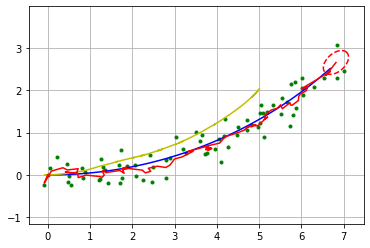

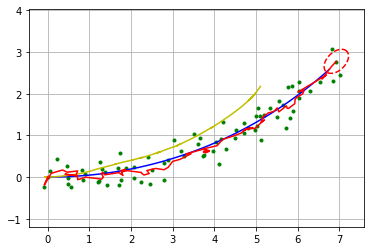

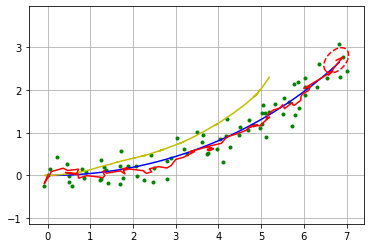

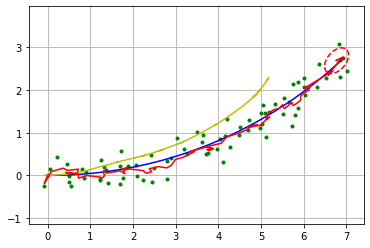

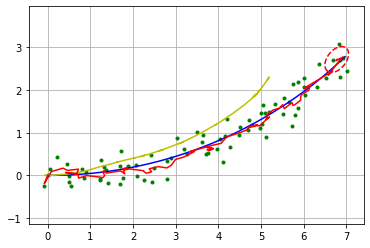

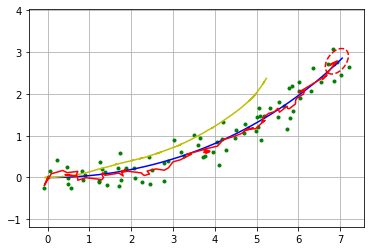

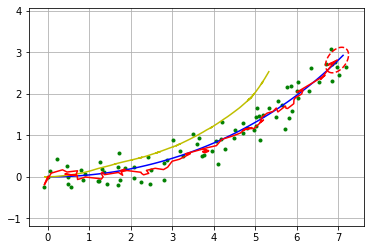

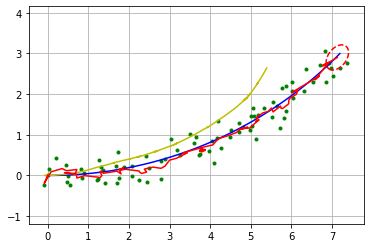

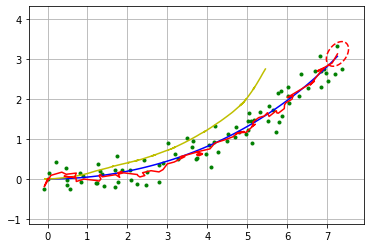

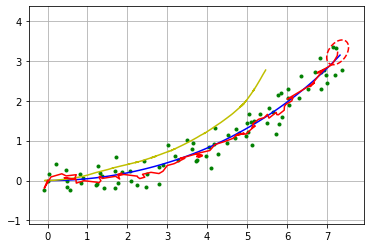

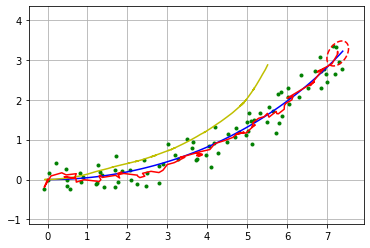

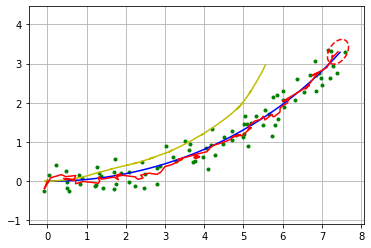

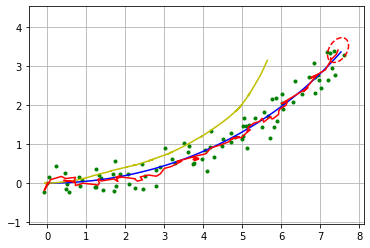

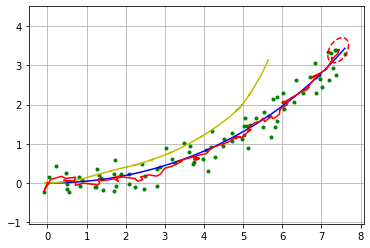

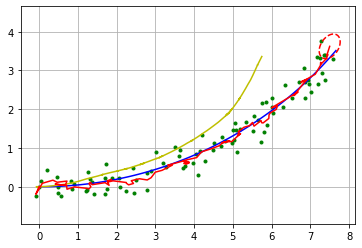

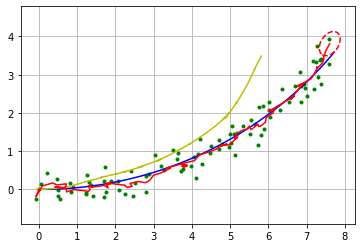

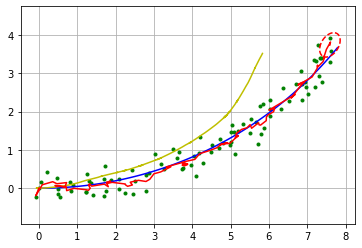

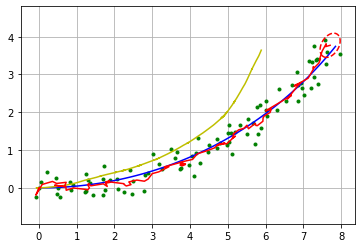

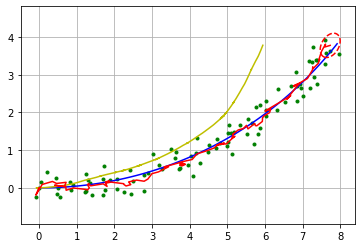

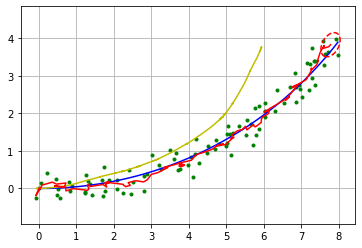

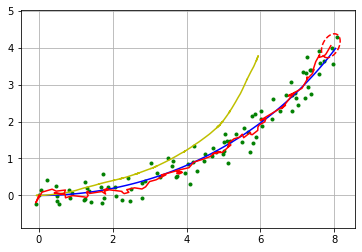

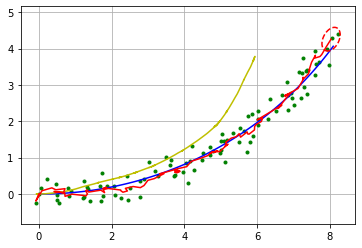

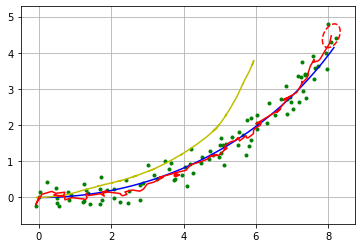

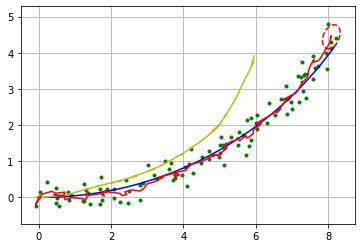

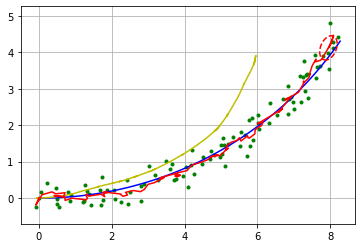

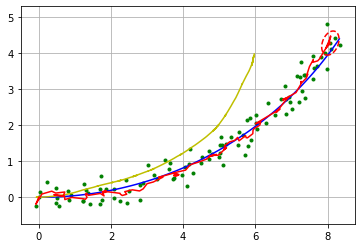

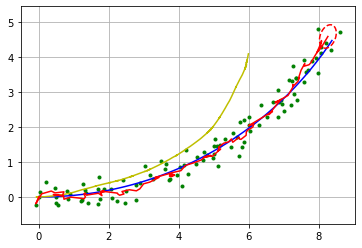

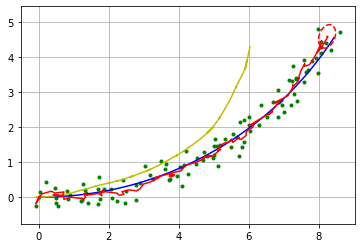

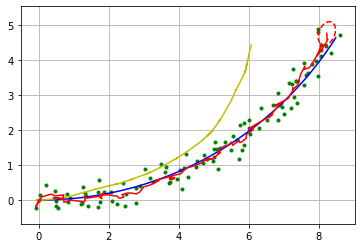

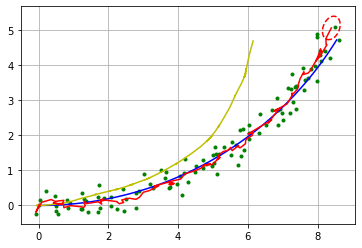

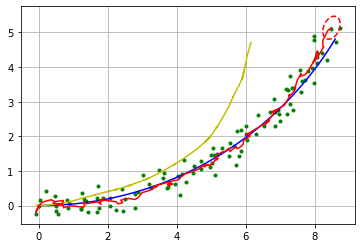

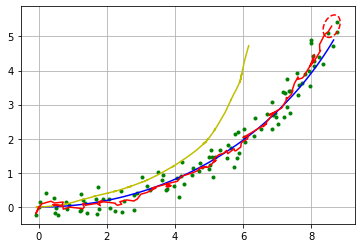

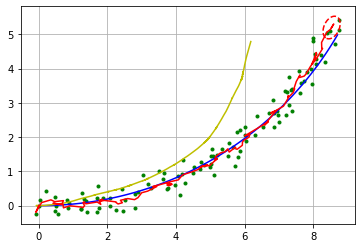

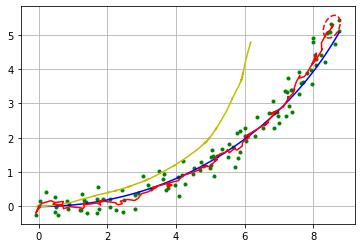

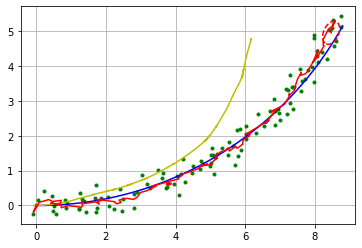

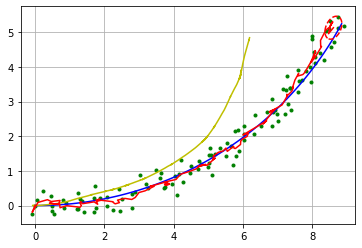

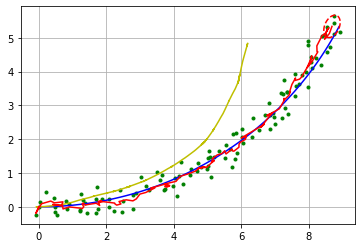

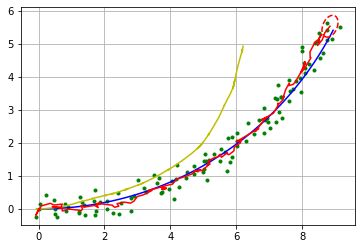

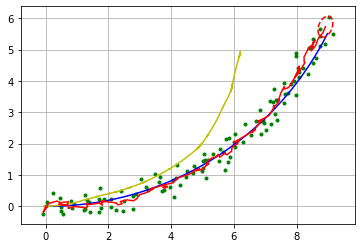

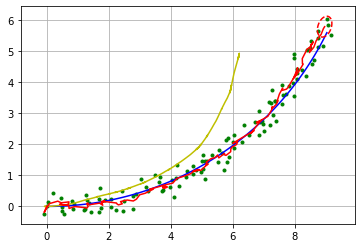

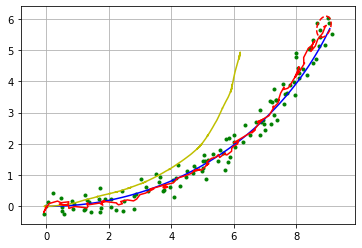

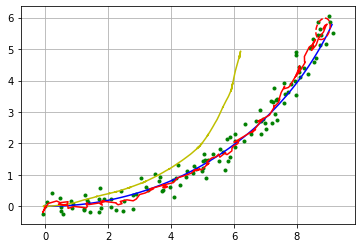

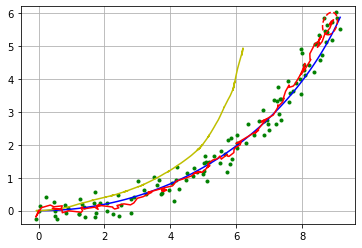

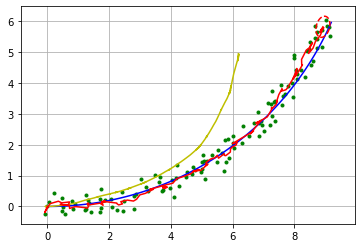

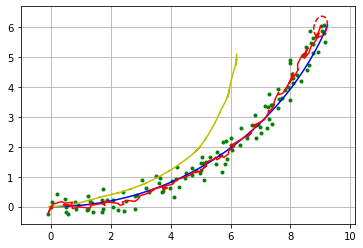

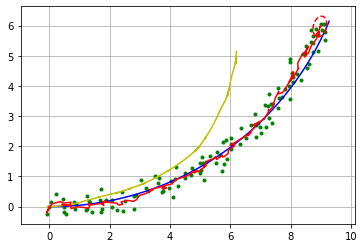

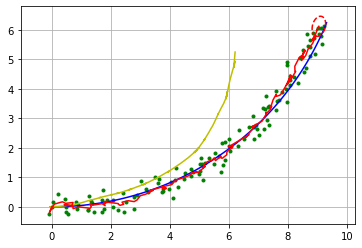

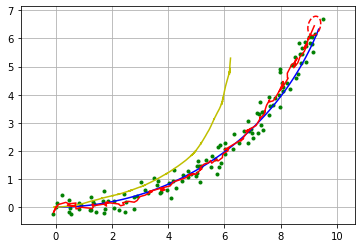

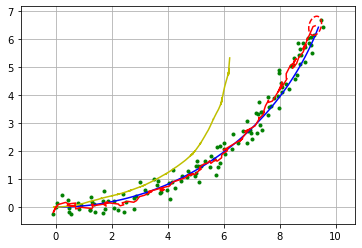

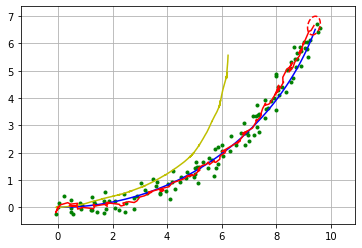

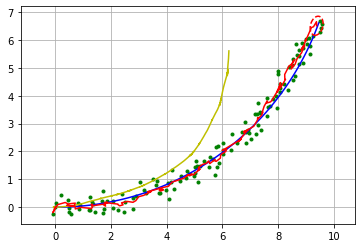

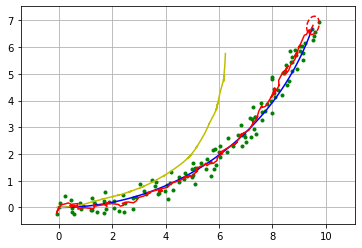

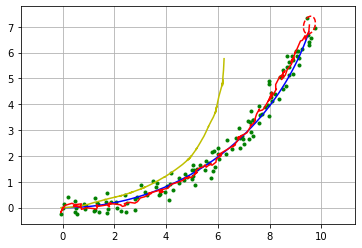

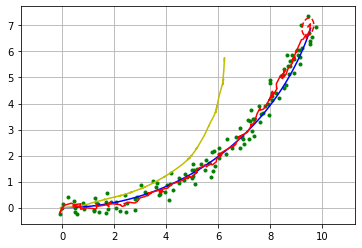

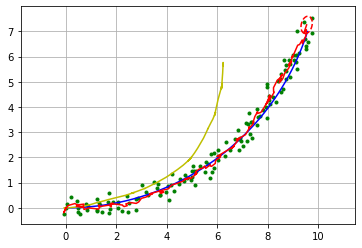

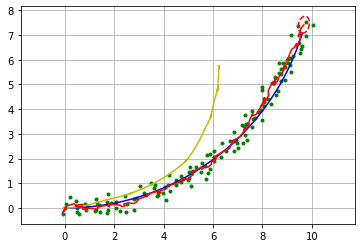

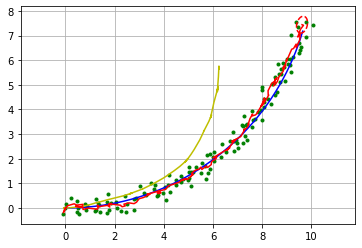

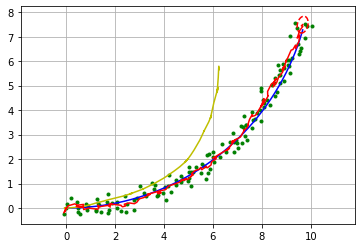

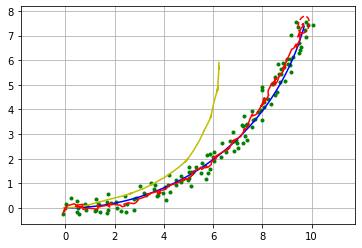

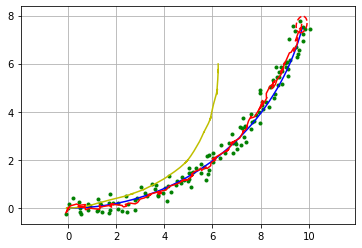

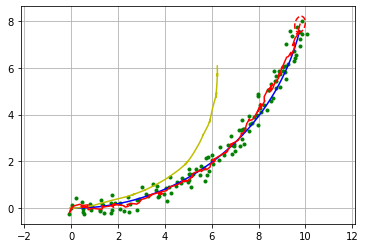

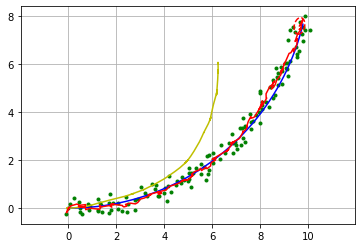

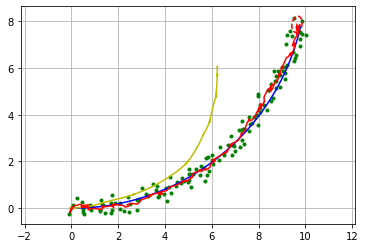

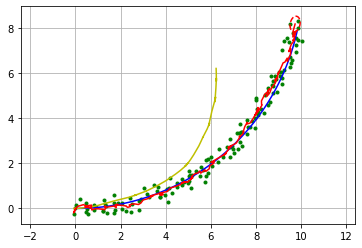

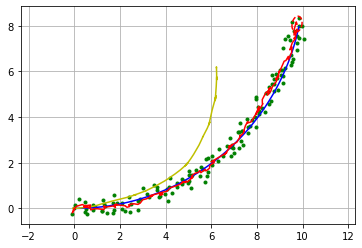

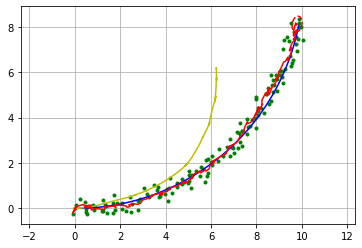

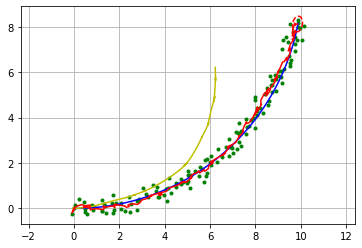

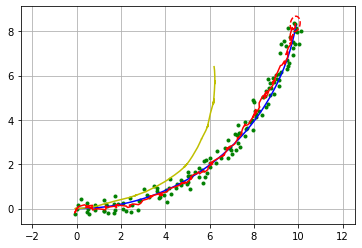

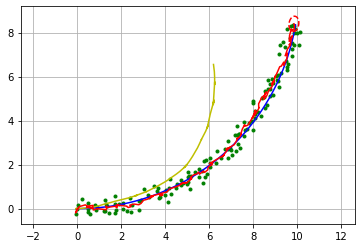

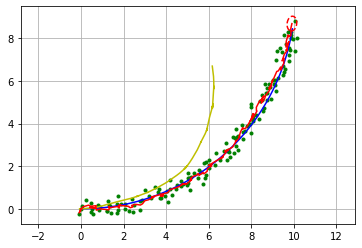

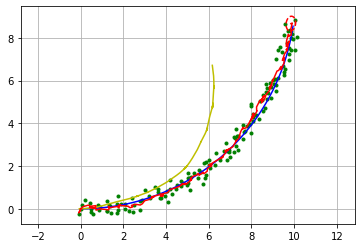

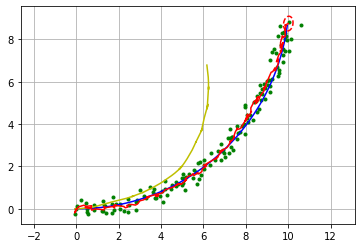

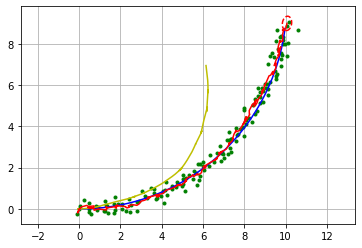

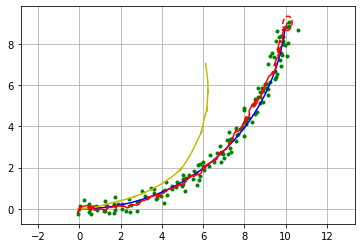

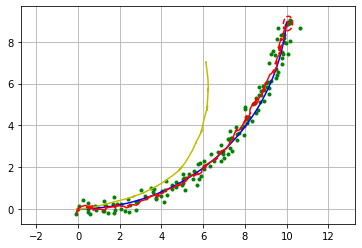

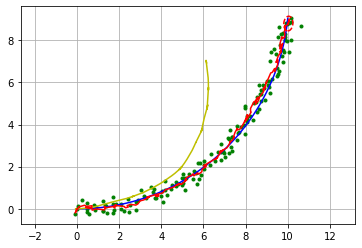

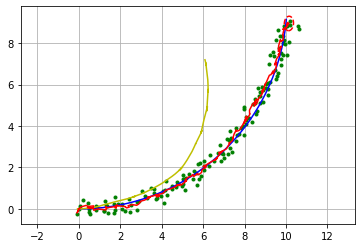

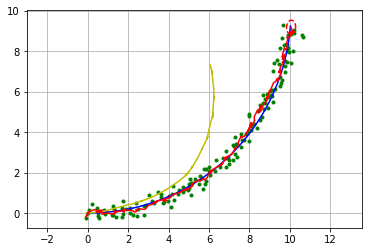

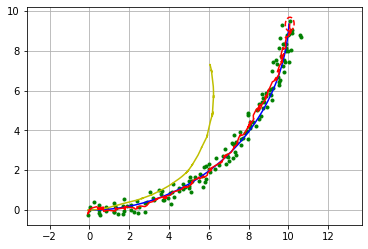

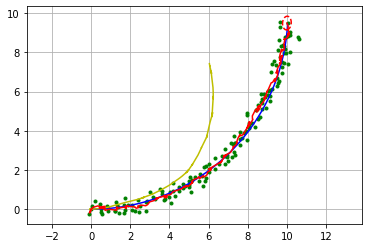

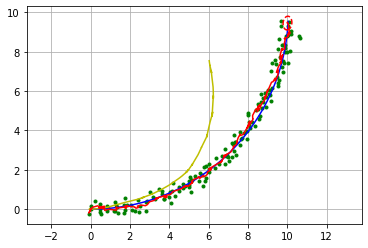

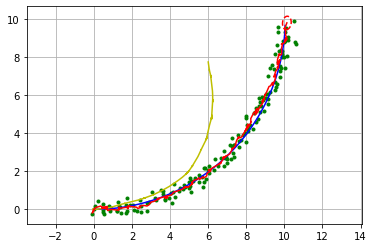

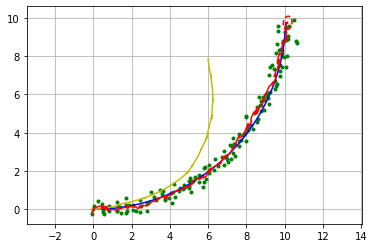

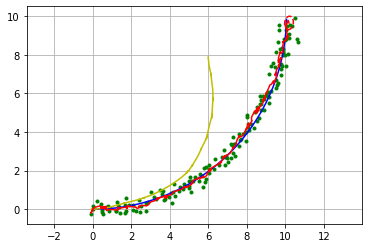

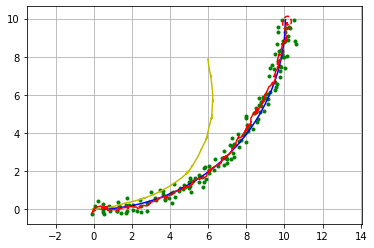

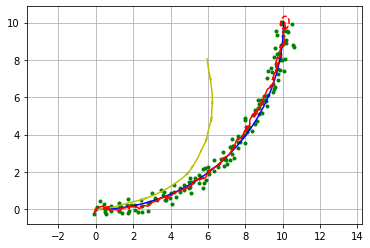

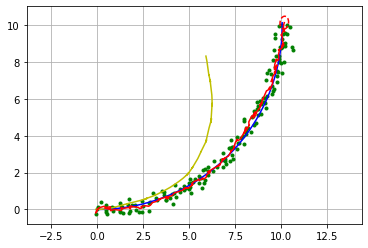

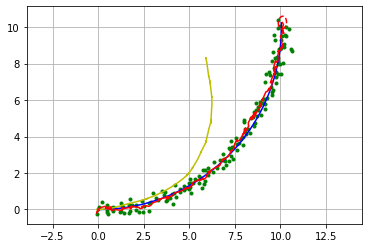

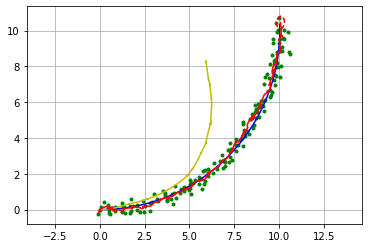

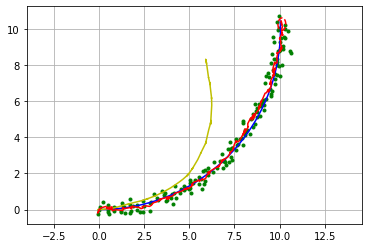

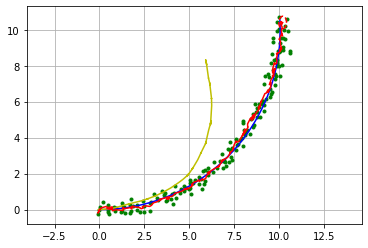

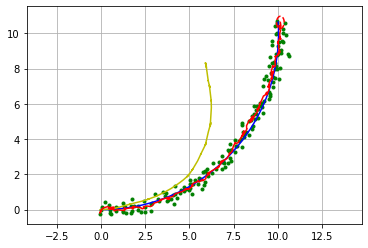

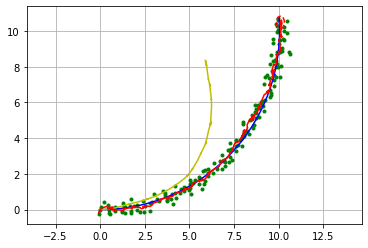

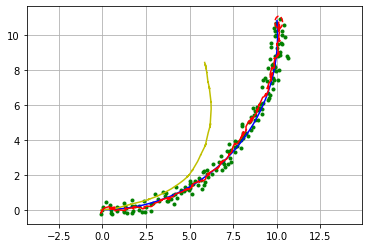

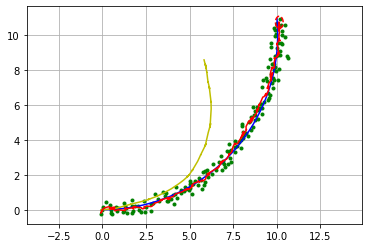

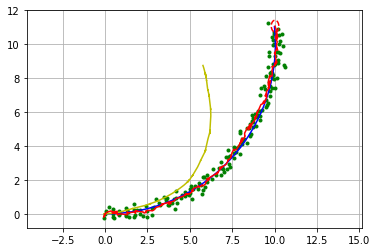

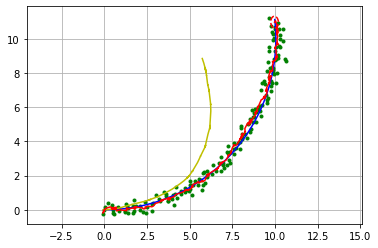

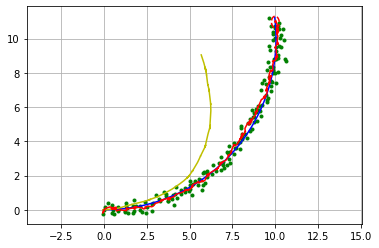

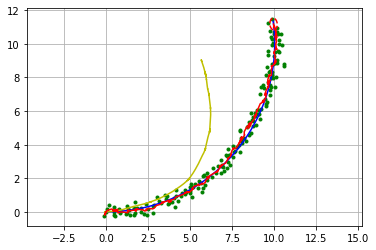

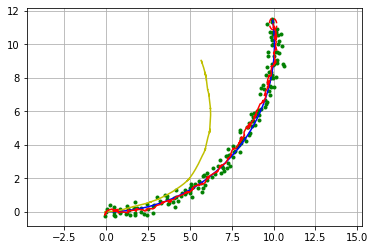

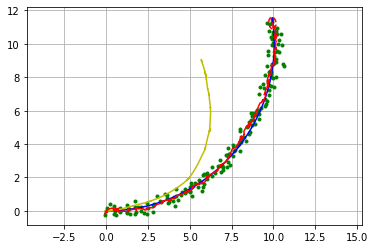

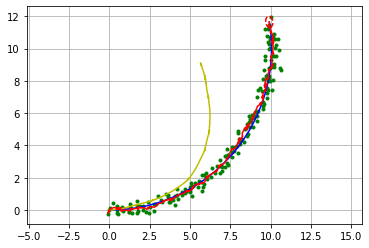

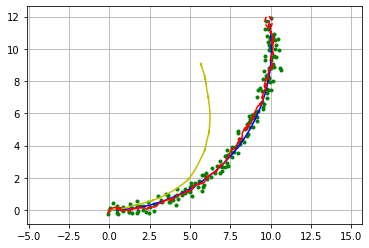

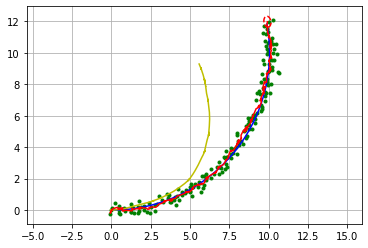

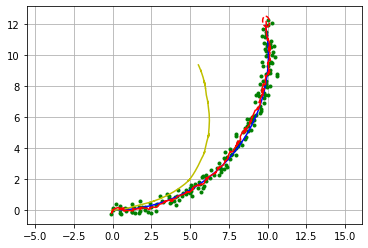

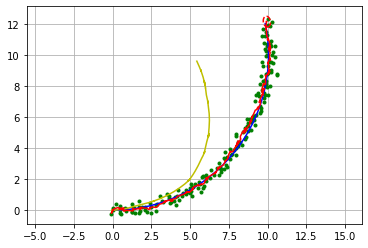

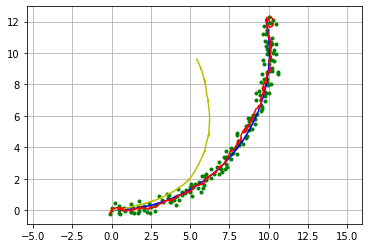

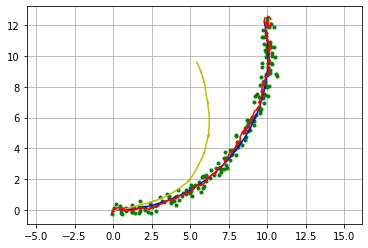

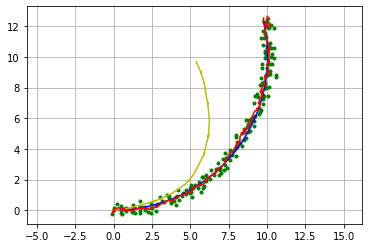

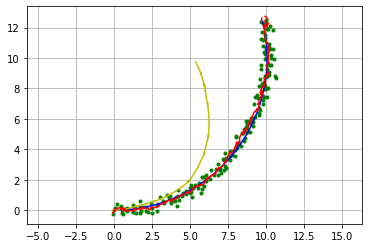

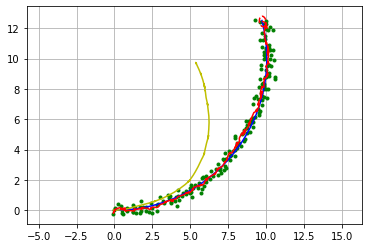

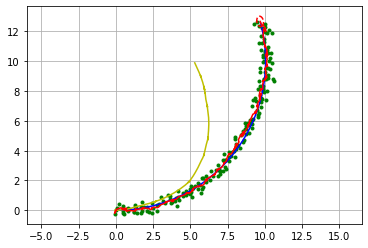

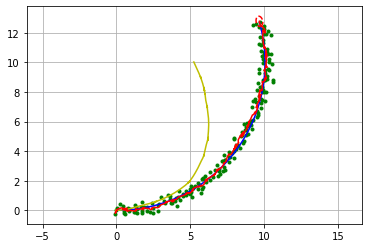

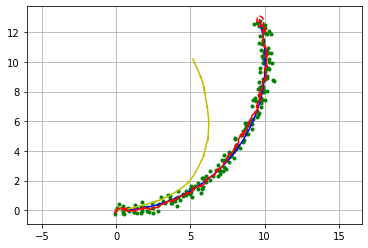

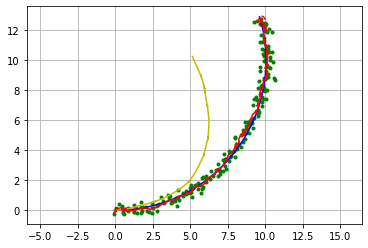

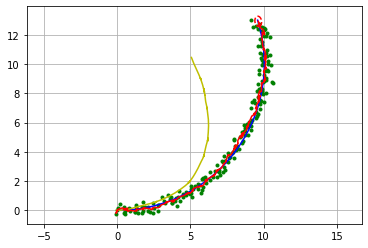

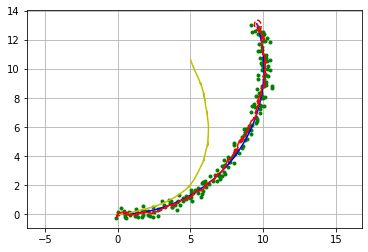

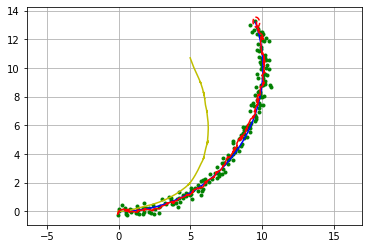

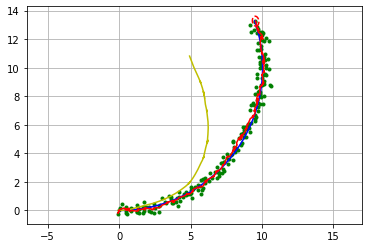

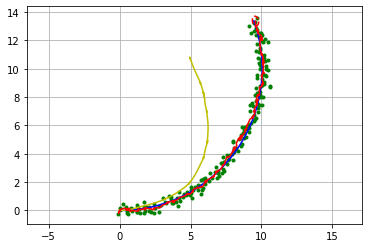

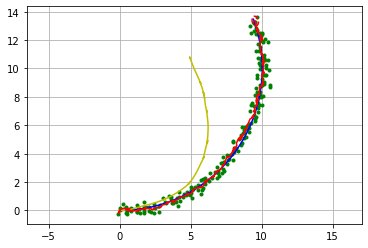

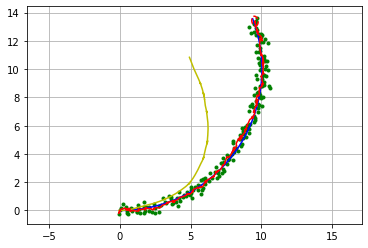

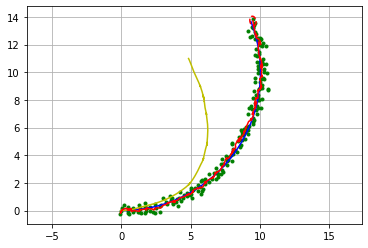

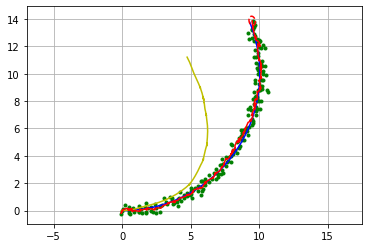

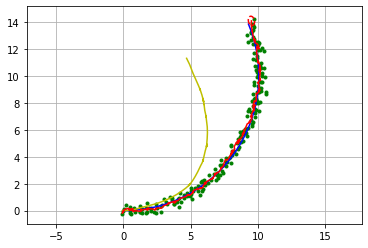

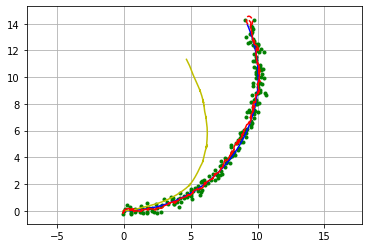

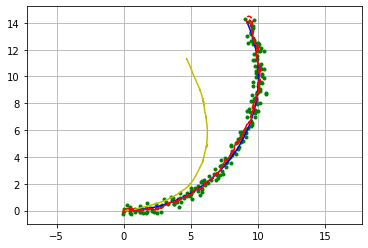

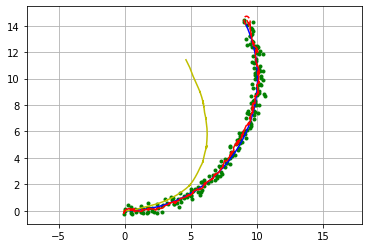

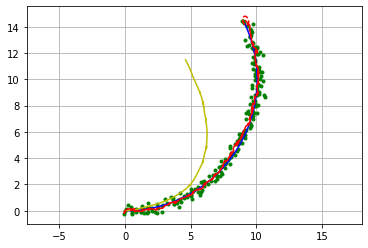

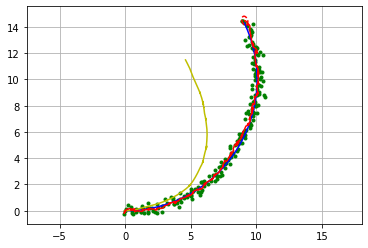

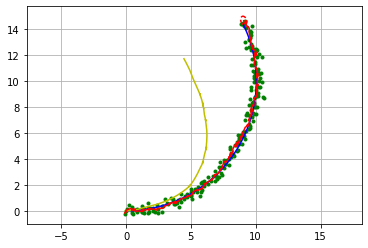

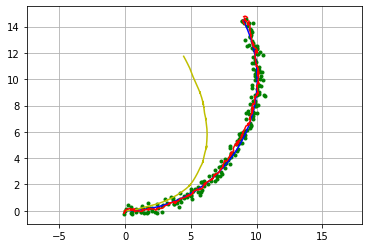

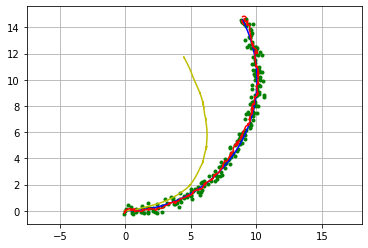

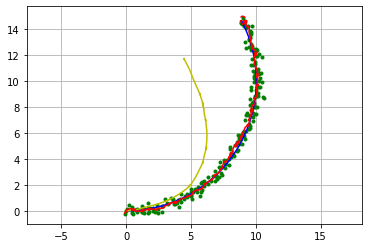

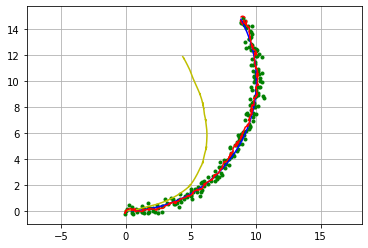

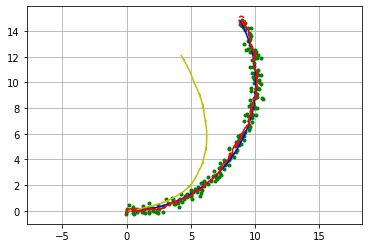

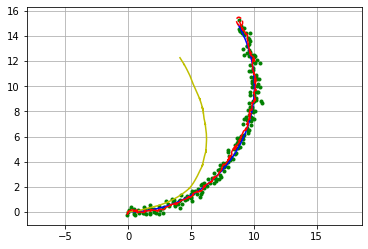

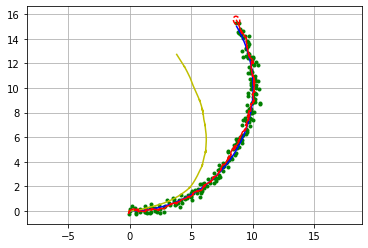

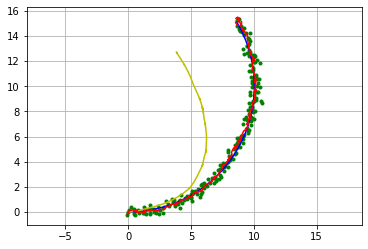

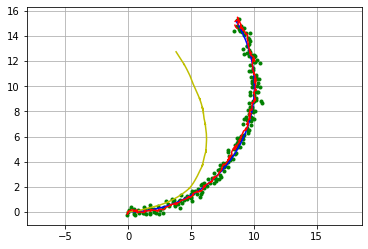

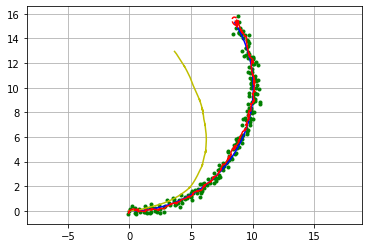

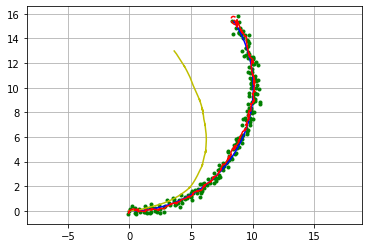

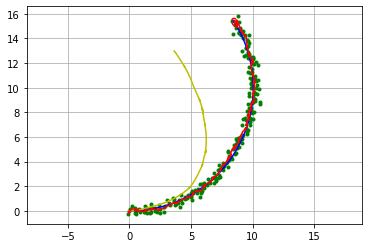

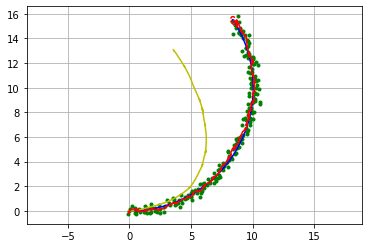

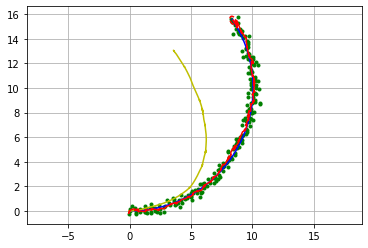

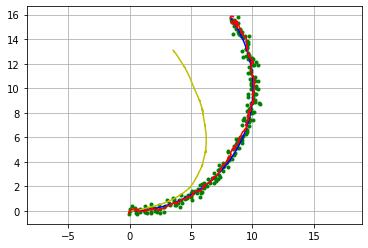

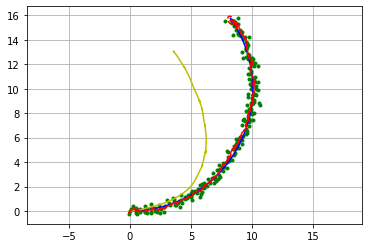

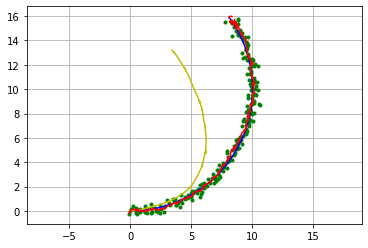

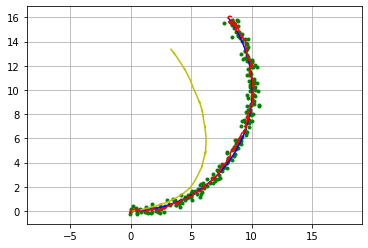

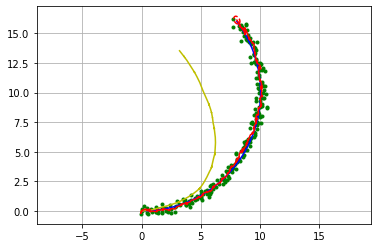

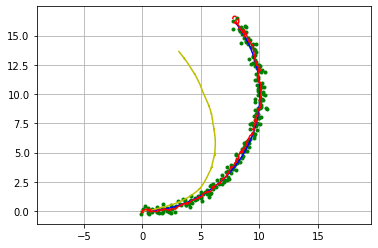

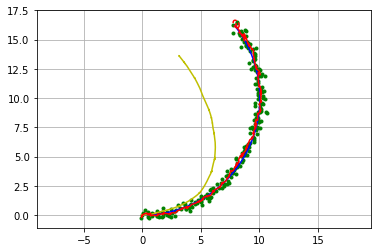

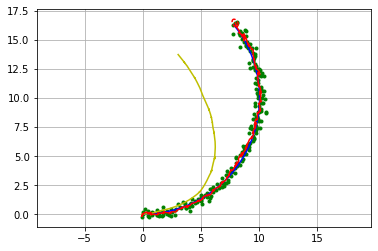

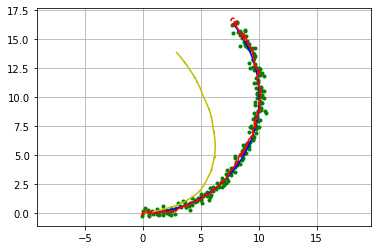

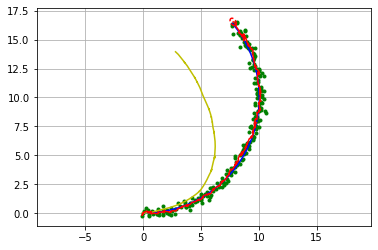

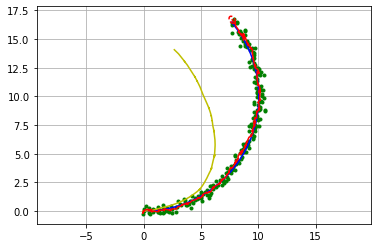

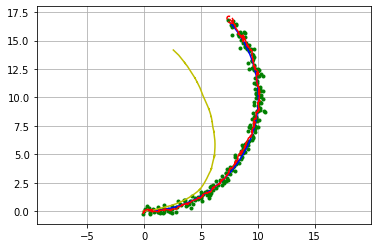

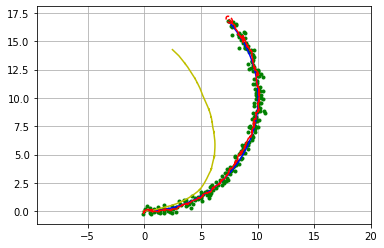

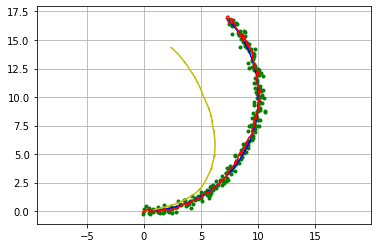

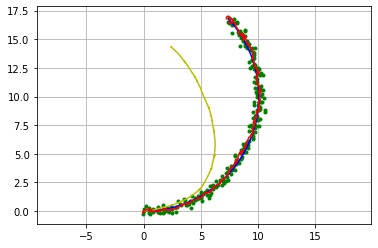

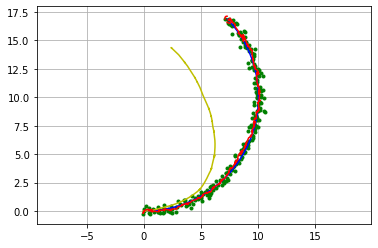

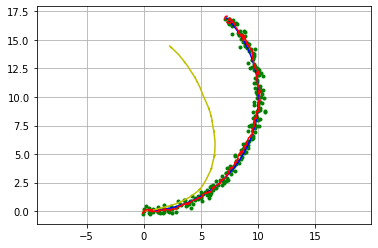

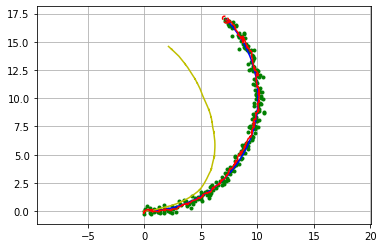

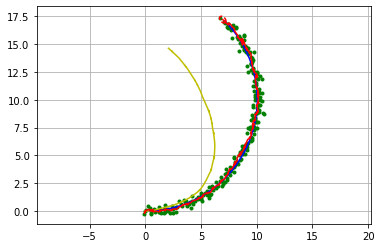

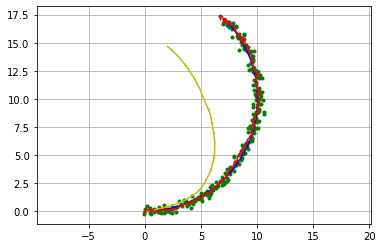

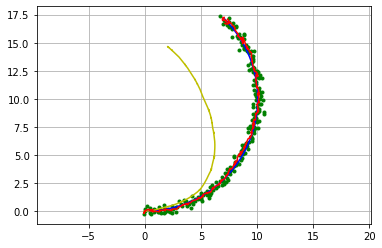

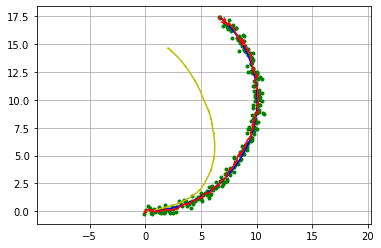

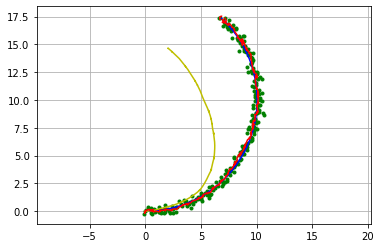

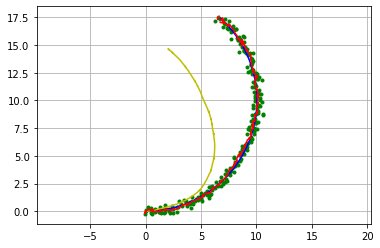

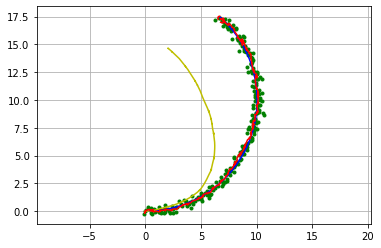

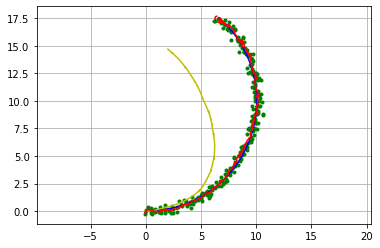

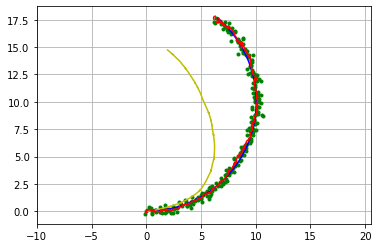

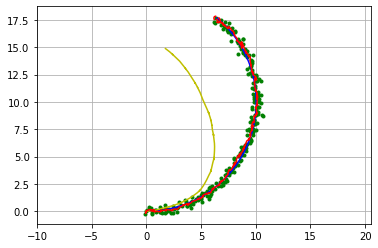

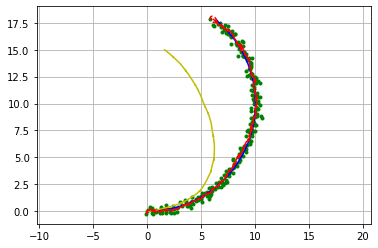

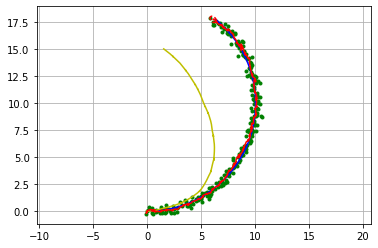

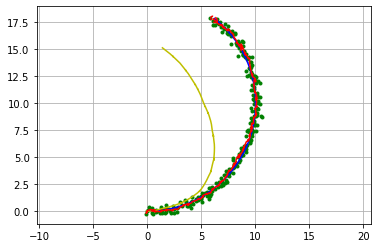

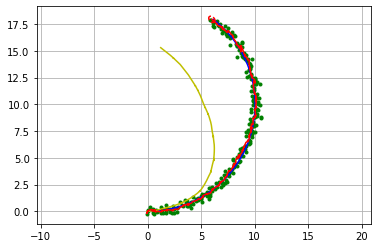

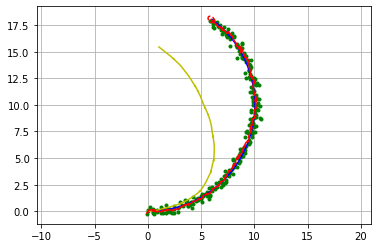

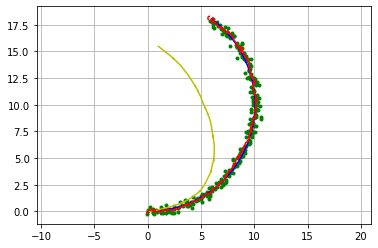

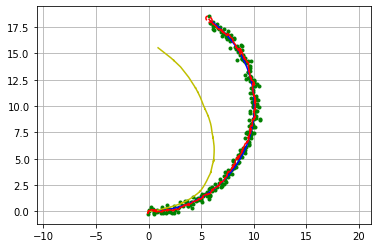

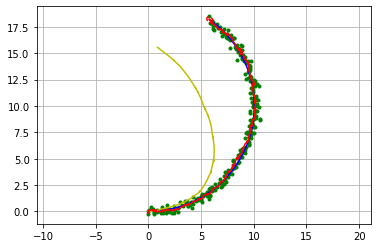

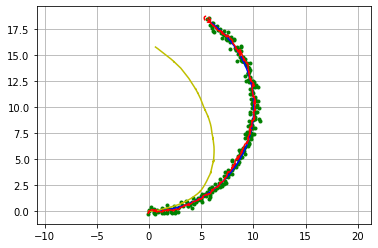

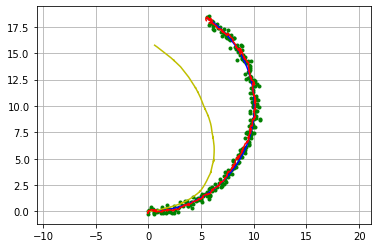

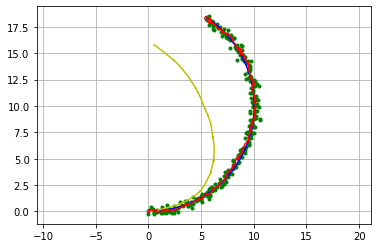

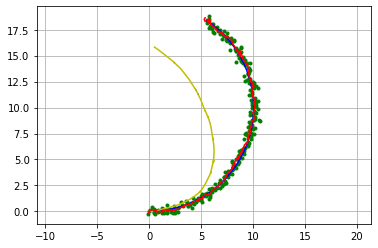

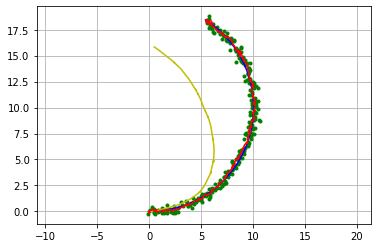

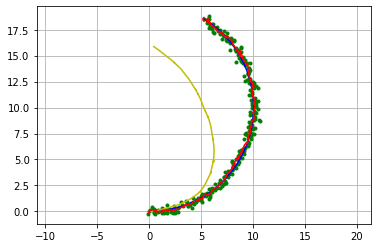

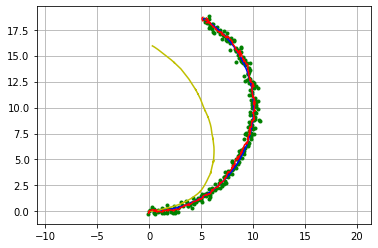

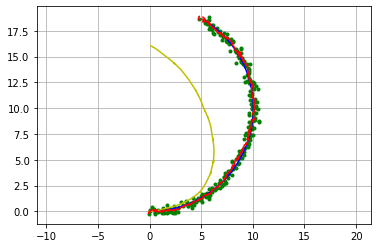

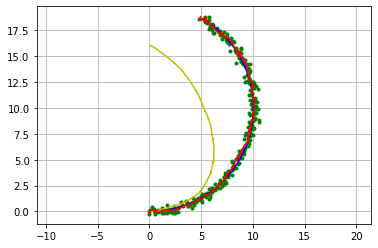

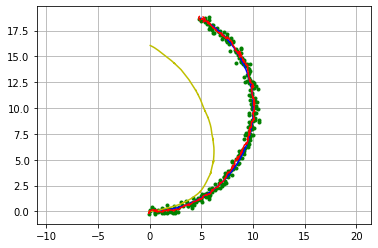

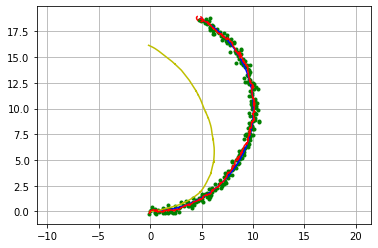

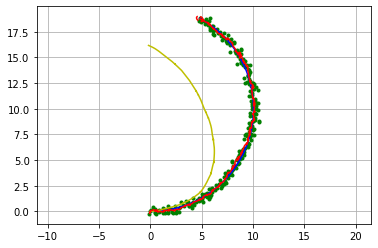

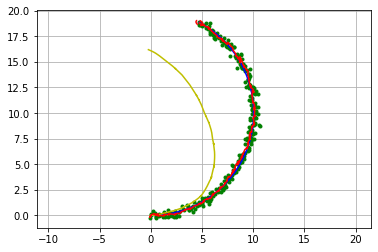

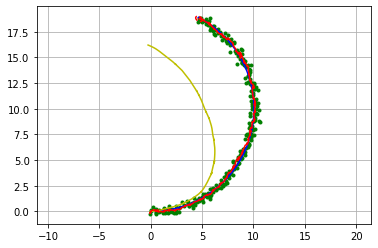

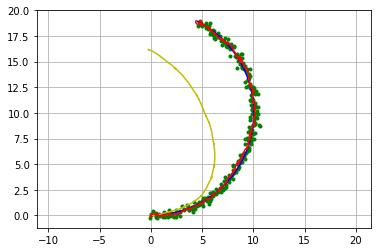

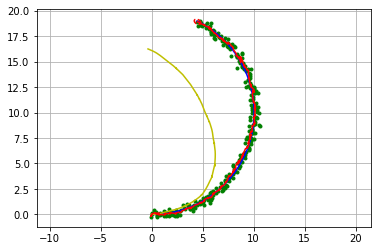

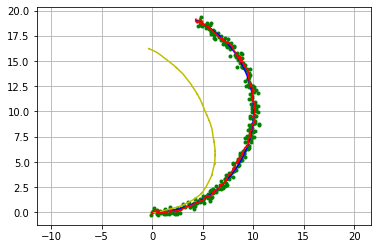

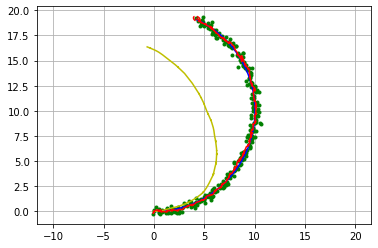

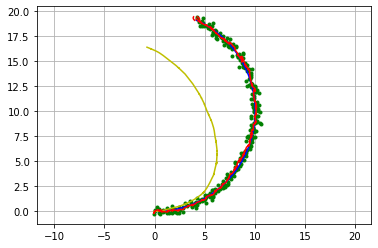

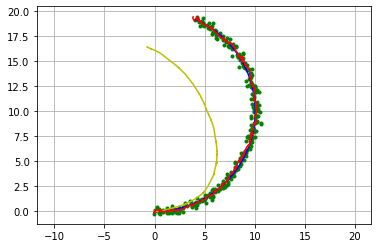

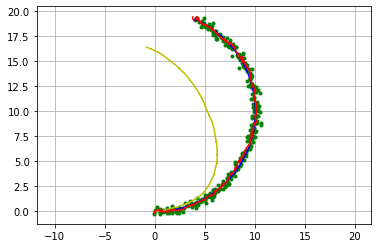

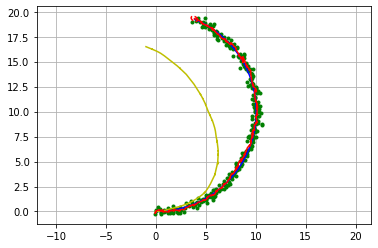

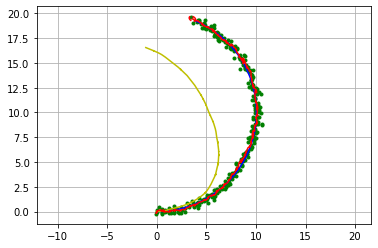

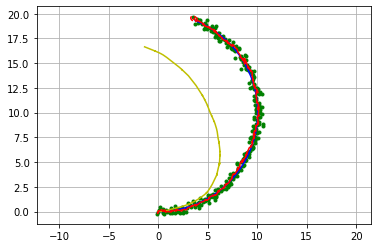

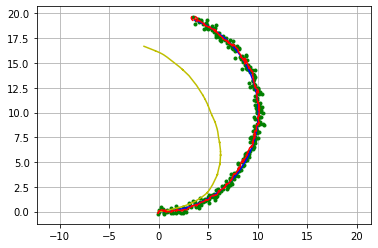

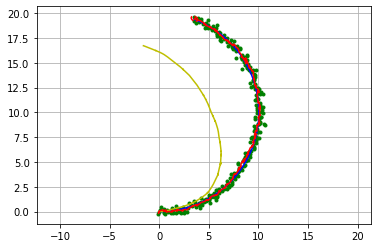

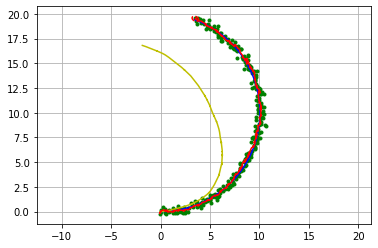

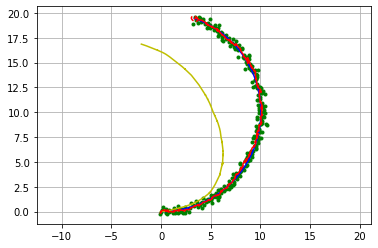

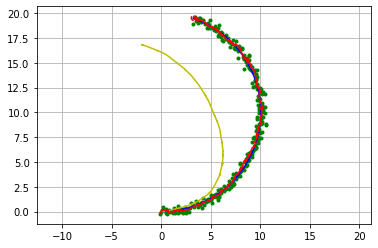

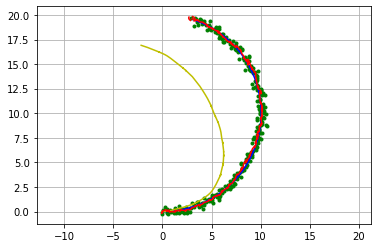

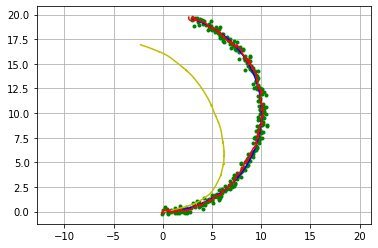

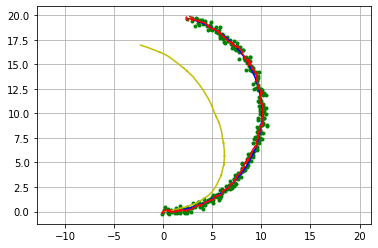

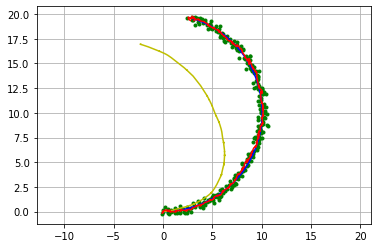

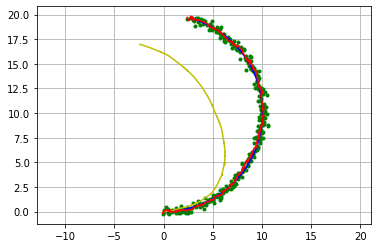

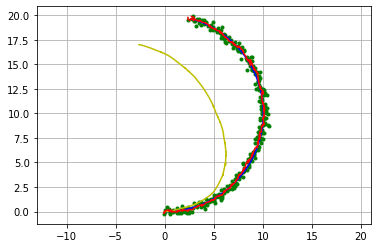

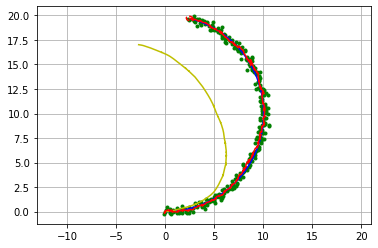

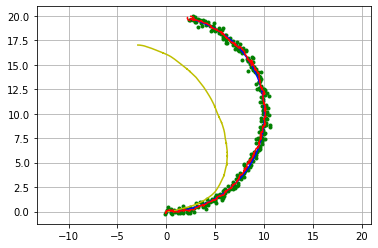

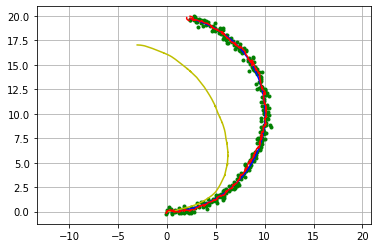

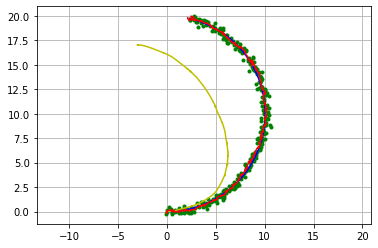

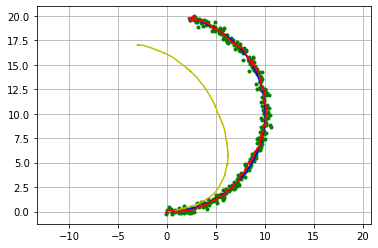

KeyboardInterrupt: 

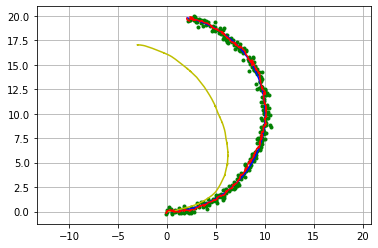

In [51]:
if __name__ == '__main__':
    main()